In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import qutip
import numpy as np
import qutip
import scqubits
from scipy.optimize import minimize
from IPython.display import clear_output

from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
from CoupledQuantumSystems.noise import *
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.IFQ import gfIFQ

In [3]:
EJ = 4
EC = EJ/2.7
EL = EJ/45

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=13)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(10)]

t_duration = 50
tlist = np.linspace(0,t_duration,t_duration)

# Step-1 optimize without decay

[2.84351759 2.82703816]


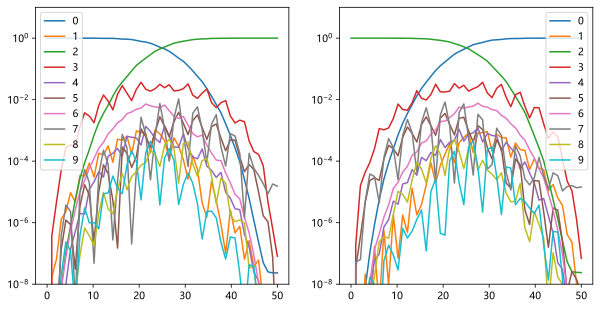

(3.249940417893171e-05, 3.242524851498896e-05)


In [10]:

def objective(x):
    
    amp1_scaling_factor = x[0]
    amp2_scaling_factor = x[1]
    # amp1_correction_scaling_factor = x[2]
    # amp2_correction_scaling_factor = x[3]
    # detuning1 =x[2]
    # detuning2 =x[3]
    detuning1 =0.5
    detuning2 =0.5
    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
        tlist = tlist,
        drive_terms = qbt.get_Raman_DRAG_drive_terms(
            i = 0,
            j = 3,
            k = 2,
            detuning1=detuning1,
            detuning2 = detuning2,
            t_duration=t_duration,
            shape='sin^2',
            amp_scaling_factor = 1,
            amp1_scaling_factor = amp1_scaling_factor,
            amp2_scaling_factor = amp2_scaling_factor,
            amp1_correction_scaling_factor = 0,
            amp2_correction_scaling_factor = 0,
        ),
        # c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
    one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop0))
    return one_minus_pop2 + one_minus_pop0

initial_guess =[3.6 , 3.6]


result = minimize(objective, initial_guess, method='Nelder-Mead')



# Step-2 turn on decay, compute the fidelity

 Total run time:   1.06s*] Elapsed 1.06s / Remaining 00:00:00:00[*********87%********   ] Elapsed 1.07s / Remaining 00:00:00:000[******   28%           ] Elapsed 0.21s / Remaining 00:00:00:000
 Total run time:   1.16s*] Elapsed 1.16s / Remaining 00:00:00:00 [*********91%*********  ] Elapsed 1.16s / Remaining 00:00:00:00
 Total run time:   1.18s*] Elapsed 1.18s / Remaining 00:00:00:00 [*********98%***********] Elapsed 1.17s / Remaining 00:00:00:00
 Total run time:   1.25s*] Elapsed 1.25s / Remaining 00:00:00:00 [*********97%********** ] Elapsed 1.24s / Remaining 00:00:00:00
 Total run time:   1.28s*] Elapsed 1.28s / Remaining 00:00:00:00
 Total run time:   1.32s*] Elapsed 1.32s / Remaining 00:00:00:00


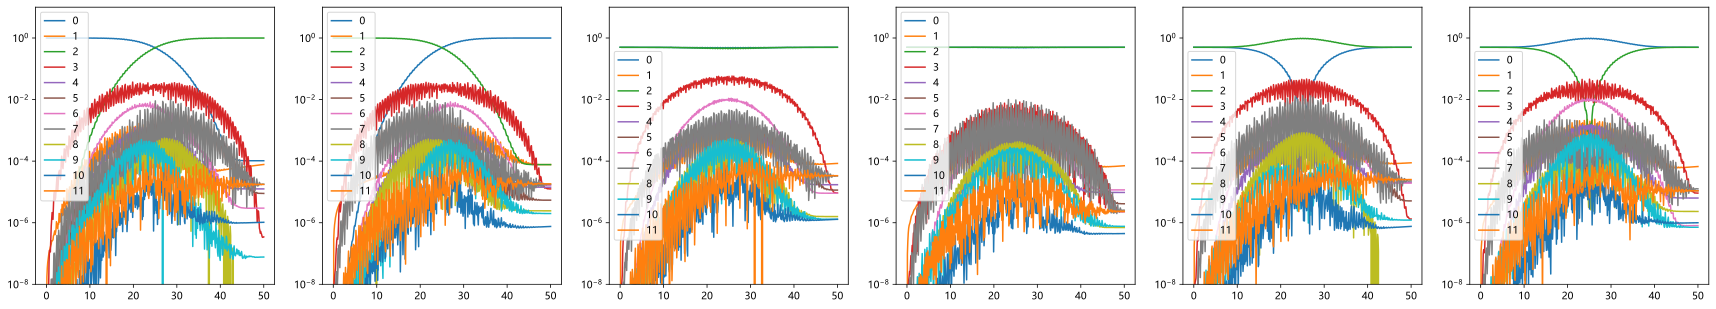

In [11]:
state_0_dressed = qutip.basis(qbt.truncated_dim, 0)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

tlist = np.linspace(0,t_duration,10*t_duration)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(10)]


amp1_scaling_factor = 2.84351759
amp2_scaling_factor =  2.82703816

detuning1 =0.5
detuning2 =0.5

temp_in_mK = 20
loss_tangent_ref = 5e-6
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(12)]


results  = qbt.run_qutip_mesolve_parrallel(
    initial_states = initial_states,
    tlist = tlist,
    drive_terms = qbt.get_Raman_DRAG_drive_terms(
        i = 0,
        j = 3,
        k = 2,
        detuning1=detuning1,
        detuning2 = detuning2,
        t_duration=t_duration,
        shape='sin^2',
        amp_scaling_factor = 1,
        amp1_scaling_factor = amp1_scaling_factor,
        amp2_scaling_factor = amp2_scaling_factor,
        amp1_correction_scaling_factor = 0,
        amp2_correction_scaling_factor = 0,
    ),
    c_ops = c_ops,
    e_ops = e_ops
)

fig, axes = plt.subplots(1,6,figsize = (30,5))
for i, (result,ax) in enumerate(zip(results,axes)):
    for i, exp in enumerate(result.expect):
        ax.plot(tlist,exp,label= f"{i}")
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(1e-8,1e1)

In [12]:

def truncate_to_computational(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

states_ideal_after_gate = []
for state in states_ideal:
    states_ideal_after_gate.append(qutip.qip.operations.x_gate() * state)


def calc_average_fidelity_with_phase(phase,dms,states_ideal_after_gate):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal_after_gate):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


from scipy.optimize import minimize
dms = [truncate_to_computational(result.states[-1], 0,2) for result in results]
def objective_function(phase):
    return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
print(f"infidelity: {opt_result.fun}, phase {opt_result.x[0]}")

infidelity: 4.2780374850726055e-05, phase 4.339574880425517


In [13]:
gate = qutip.qip.operations.phasegate(4.352403649482513)
for dm,ket_ideal in zip(dms,states_ideal_after_gate):
    print(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))

0.9999484252683785
0.9999613972902569
0.9999015068859374
0.9999790242072017
0.9999206547961031
0.9999499183337297


In [14]:
def get_leakage_trace(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    return 1-dm.tr()

leakage_list = [get_leakage_trace(result.states[-1], 0,2) for result in results]

leakage_list,np.mean(leakage_list)

([0.00013859594358600624,
  0.00016717171889779614,
  0.00020239435388846871,
  0.00010546489538043602,
  0.00018412509014553713,
  0.00012179867358530494],
 0.00015325844591392487)

In [15]:
def get_e_pop(state):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,1)), state)

e_list = [get_e_pop(result.states[-1]) for result in results]

e_list,np.mean(e_list)

([7.798600703133317e-05,
  7.740200883344136e-05,
  8.44415670496738e-05,
  7.096373420669728e-05,
  8.847780577833068e-05,
  6.696803165307919e-05],
 7.770652575875925e-05)